## Introduction

This tutorial illustrates concepts of geospatial data. In this notebook, you will see what data formats you will encounter when working with geospatial data as well as what each data format represents. Also, you will learn basic geospatial data processing using 2 Python libraries: `rasterio` and `geopandas`.

### Geospatial Data
Geospatial data is data about objects or places that have a location on the surface of the earth. It combines location information(coordinates on earth) with the attributes about objects or places such as measurements received from sensors. Examples of geospatial data are satellite imagery and point clouds.


#### Data Types 
Geospatial data consists of 2 data formats: <i>vector</i> and <i>raster</i>

##### Raster
Raster data is an image representing a specific scene on the earth surface. Unlike normal image which only contains pixel intensity, raster image comes with geographic information which means the whole image as well as every pixel in it can be mapped to the exact location on earth.

##### Vector
Vector data contains information about the location of objects or locations in the form of `Line`, `Point`, and `Polygon`. 

### Working with Raster

To work with raster data, we're going to use the Python package name `rasterio` which provides so many functions for manipulating raster image. In this tutorial, the raster data we use is images taken from Sentinel-2 satellite. However, the concept can be applied to all raster data.

Dataset profile : {'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': 0.0, 'width': 2051, 'height': 2051, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 754360.0,
       0.0, -10.0, 1688690.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


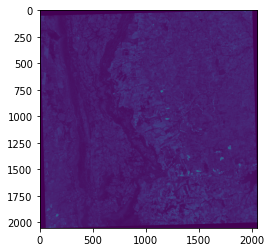

In [1]:
import rasterio
import matplotlib.pyplot as plt

# Open image files
B02_dataset = rasterio.open('data/image/20210101/IMG_DATA/47PQS_20210101_B02.jp2')

print(f'Dataset profile : {B02_dataset.profile}')

# Read image data from dataset
B02 = B02_dataset.read(1)

plt.figure()
plt.imshow(B02)

Apart from image data, another important part of raster data is the dataset `profile`. Dataset profile is a metadata about the dataset such as image size, number of channels, and data type.

There are 2 attributes of dataset profile that you will use frequently: `transform` and `crs`. `transform` is a transformation matrix that maps the image into the exact location on the earth surface based on the co-ordinate system define in `crs` field. These 2 properties are crucial in many scenarios and you'll find that in this tutorial later on.

In [2]:
print(B02_dataset.profile['crs'])
print(B02_dataset.profile['transform'])

EPSG:32647
| 10.00, 0.00, 754360.00|
| 0.00,-10.00, 1688690.00|
| 0.00, 0.00, 1.00|


#### Vegetation Index

Vegetation Index(VI) is an image transformation technique that combines two or more to enhance vegetation properties. There are many VIs in remote sensing but the one that is most commonly used in agriculture is <i>Normalized Difference Vegetation Index</i>(<i>NDVI</i>). NDVI is also known as plant health index.

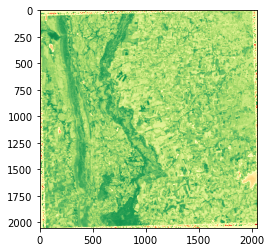

In [3]:
import numpy as np

R = rasterio.open('data/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2').read(1).astype(float)
NIR = rasterio.open('data/image/20210101/IMG_DATA/47PQS_20210101_B08.jp2').read(1).astype(float)
NDVI = np.divide(NIR - R, NIR + R, out=np.zeros_like(R), where=(NIR + R) != 0)
plt.figure()
plt.imshow(NDVI, cmap='RdYlGn', vmin=-1, vmax=1)

### Working with Vector
Another Python package that is used frequently in processing geospatial data is `geopandas`. Geopandas offers many functionalities that make dealing with vector data easier.

The vector data we're going to use in this tutorial indicating farm boundaries and the crop type growing in the area.

In [5]:
import geopandas

vector = geopandas.read_file('data/shape/training_area/train_data.shp') # Read vector data from shape file
vector = vector.to_crs(B02_dataset.profile['crs'])                      # Convert to the same co-ordinate as raster
vector.head()

,years,crop_type,geometry
0,2021,1,"POLYGON ((774604.014 1671240.055, 774606.506 1..."
1,2021,1,"POLYGON ((773367.837 1670278.438, 773389.600 1..."
2,2021,1,"POLYGON ((771648.671 1673990.960, 771707.027 1..."
3,2021,3,"POLYGON ((771306.117 1674174.738, 771426.678 1..."
4,2021,2,"POLYGON ((763750.339 1678588.825, 763879.691 1..."


The column `geometry` represents the boundary of the farm and could be used to locate where the farm is on the raster image. Apart from `geometry`, vector data can also contain other data associated with the farm such as `crop_type`.

<AxesSubplot:>

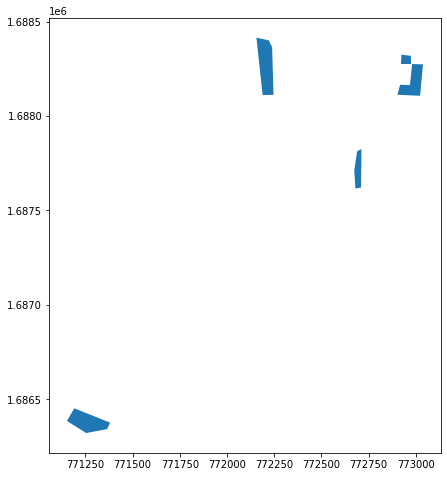

In [6]:
# Visulize vector data
vector[102:107].plot(figsize=(8,8))

### Working Raster and Vector simultaneously
When working with geospatial data, it's very likely that you will have to deal with both raster and vector data simultaneously. Here are a few common usecases of combining raster and vector data.

#### Getting all pixels inside a polygon
Raster image normally covers a very large area on the earth surface. However, we're usually not interested in all area of the raster image but only the one within polygons. Therefore, we need to select only pixels that are in the region of interest to make sure that we get the data that is relevant.

In the code below, we use `rasterio` to select pixels inside the farm polygon and compute NDVI statistics of the farm.

NUM PIXELS : 83
MEAN NDVI : 0.4967728172662949
MAX  NDVI : 0.6950916082334313
MIN  NDVI : 0.35558112773302647
STD  NDVI : 0.07510134668226044


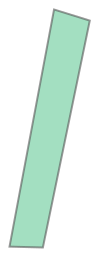

In [10]:
from rasterio.features import geometry_mask

R_dataset = rasterio.open('data/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2')
NIR_dataset = rasterio.open('data/image/20210101/IMG_DATA/47PQS_20210101_B08.jp2')
R = R_dataset.read(1).astype(float)
NIR = NIR_dataset.read(1).astype(float)
NDVI = np.divide(NIR - R, NIR + R, out=np.zeros_like(R), where=(NIR + R) != 0)

polygon = vector['geometry'][7]
out_shape = (R_dataset.profile['width'], R_dataset.profile['height'])
# Create a binary image where all pixels inside polygon is True, otherwise False
mask = geometry_mask(geometries=[polygon], out_shape=out_shape, transform=R_dataset.profile['transform'], invert=True)
polygon_pixels = NDVI[mask] # Apply mask to the NDVI image

# Compute NDVI statistics of a farm
print(f'NUM PIXELS : {len(polygon_pixels)}')
print(f'MEAN NDVI : {np.mean(polygon_pixels)}')
print(f'MAX  NDVI : {np.max(polygon_pixels)}')
print(f'MIN  NDVI : {np.min(polygon_pixels)}')
print(f'STD  NDVI : {np.std(polygon_pixels)}')
polygon

### Cropping Raster using Polygon
Although selecting pixels inside polygon can give you meaningful insights, there are some information losing during the process especially those that is positional-related. This information is very useful especially for visualization purposes. We can use `rasterio` and `geopandas` to crop raster data using a polygon as follow:

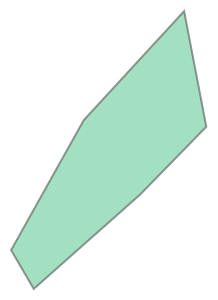

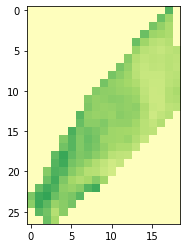

In [34]:
from rasterio.windows import Window
from rasterio.features import bounds

R_dataset = rasterio.open('data/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2')
NIR_dataset = rasterio.open('data/image/20210101/IMG_DATA/47PQS_20210101_B08.jp2')

polygon = vector['geometry'][500]

# Create polygon bounding box
x_min, y_max, x_max, y_min = bounds(polygon)
p1_y, p1_x = R_dataset.index(x_min, y_min)
p2_y, p2_x = R_dataset.index(x_max, y_max)
# Read raster data within the bounding box and compute NDVI
window = Window(p1_x, p1_y, p2_x - p1_x, p2_y - p1_y)
window_tf = R_dataset.window_transform(window)
R = R_dataset.read(window=window).astype(float)
NIR = NIR_dataset.read(window=window).astype(float)
NDVI = np.divide(NIR - R, NIR + R, out=np.zeros_like(R), where=(NIR + R) != 0)

# Generate geometry mask and apply
polygon_mask = geometry_mask([polygon], out_shape=(p2_y - p1_y, p2_x - p1_x), transform=window_tf, invert=True)
masked_data = NDVI * polygon_mask
plt.imshow(masked_data[0], cmap='RdYlGn', vmin=-1, vmax=1)
polygon